In [1]:
import os
import logging
import tempfile
from pathlib import Path

import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio.plot
from rasterio.enums import Resampling

here = Path.cwd() / "data"

# raster_methods.py -- old
from raster_methods import convert_crs, raster_mask, resample_to_destination
# MemoryRaster -- new
from memoryraster import MemoryRaster

# Read shapefile data
city_polygons = gpd.read_file(
    here / "vnm_adm_gov_20201027" / "vnm_admbnda_adm2_gov_20201027.shp"
)
print("  Number of city polygons =", len(city_polygons))
print("Vector co-ordinate system =", city_polygons.crs.srs)

  Number of city polygons = 708
Vector co-ordinate system = EPSG:4326


In [2]:
# Ensure that CRS of all rasters and vector are the same
#aedes_raster_file = convert_crs(here / "aegypti.tif", city_polygons.crs.srs)
#population_raster_file = convert_crs(
#    here / "vnm_ppp_2020_UNadj_constrained.tif", city_polygons.crs.srs
#)
#aedes_masked, aedes_masked_transform = raster_mask(aedes_raster_file, city_polygons.geometry)
#population_masked_high, population_masked_transform = raster_mask(population_raster_file, city_polygons.geometry)

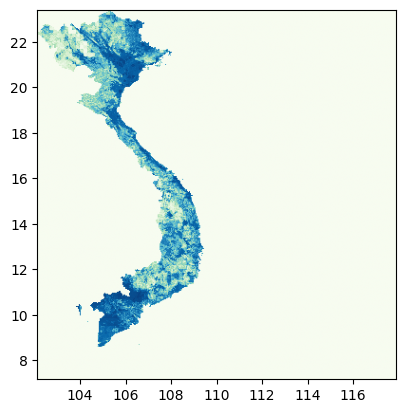

<Axes: >

In [3]:
aedes = MemoryRaster.read(here / "aegypti.tif", crs=city_polygons.crs.srs)
aedes_masked_m = aedes.mask(city_polygons)
aedes_masked_m.plot()

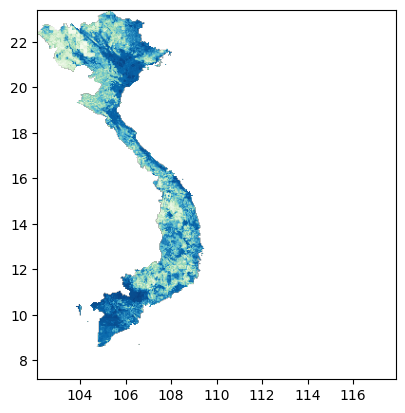

In [4]:
with aedes_masked_m.as_rasterio() as src:
    rasterio.plot.show(src, cmap='GnBu')

In [5]:
# aedes_masked.min(), aedes_masked.max()

In [6]:
# rasterio.plot.show(aedes_masked, transform=aedes_masked_transform, cmap='GnBu')

In [7]:
population_high = MemoryRaster.read(here / "vnm_ppp_2020_UNadj_constrained.tif", crs=city_polygons.crs.srs)
population_masked_high_m = population_high.mask(city_polygons).astype(np.float32)
population_masked_high_m

<MemoryRaster (17796, 8789) CRS=EPSG:4326 min=1.0159043073654175 max=28730.828125 NODATA=0 file=None
  transform=| 0.00, 0.00, 102.15|
| 0.00,-0.00, 23.39|
| 0.00, 0.00, 1.00|>

In [8]:
population_masked_high_m.sum()

np.float32(97411280.0)

In [9]:
# population_masked_low = resample_to_destination(
#     population_masked_high,
#     population_masked_transform,
#     aedes_masked,
#     aedes_masked_transform,
#     city_polygons.crs,
#     resampling=Resampling.sum
# )

In [10]:
# print(population_masked_low.shape, population_masked_low.min(), population_masked_low.max())

In [11]:
# rasterio.plot.show(population_masked_low, cmap='GnBu', norm='log', transform=aedes_masked_transform)

Resampling using: 13


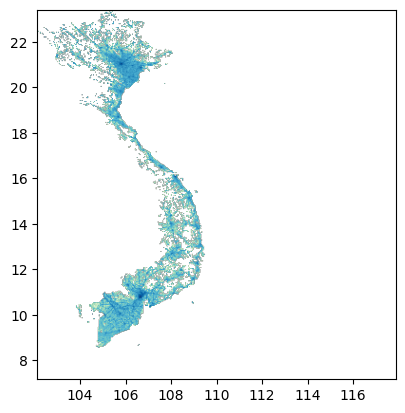

<Axes: >

In [12]:
population_masked_low_m.plot(norm='log')

In [13]:
# print("NEW SUMS (low/high):", population_masked_low_m.sum(), population_masked_high_m.sum())
# print("OLD SUMS (low/high):", np.sum(population_masked_low), np.sum(population_masked_high))


In [23]:
city_polygons[city_polygons.ADM1_EN == "Ho Chi Minh city"]

,Shape_Leng,Shape_Area,ADM2_EN,ADM2_VI,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM2ALT1VI,ADM2ALT2VI,ADM1_EN,ADM1_VI,ADM1_PCODE,ADM0_EN,ADM0_VI,ADM0_PCODE,date,validOn,validTo,geometry
51,1.148773,0.020532,Binh Chanh,Huyện Bình Chánh,VN70139,None,None,None,None,None,Ho Chi Minh city,TP. Hồ Chí Minh,VN701,Viet Nam,Việt Nam,VN,2019-10-01,2020-01-03,0000/00/00,"POLYGON ((106.54523 10.84477, 106.55325 10.843..."
61,0.358082,0.004289,Binh Tan,Quận Bình Tân,VN70140,None,None,None,None,None,Ho Chi Minh city,TP. Hồ Chí Minh,VN701,Viet Nam,Việt Nam,VN,2019-10-01,2020-01-03,0000/00/00,"POLYGON ((106.59951 10.82642, 106.60043 10.826..."
62,0.268127,0.001720,Binh Thanh,Quận Bình Thạnh,VN70129,None,None,None,None,None,Ho Chi Minh city,TP. Hồ Chí Minh,VN701,Viet Nam,Việt Nam,VN,2019-10-01,2020-01-03,0000/00/00,"POLYGON ((106.70864 10.83126, 106.70873 10.829..."
87,1.146270,0.053931,Can Gio,Huyện Cần Giờ,VN70143,None,None,None,None,None,Ho Chi Minh city,TP. Hồ Chí Minh,VN701,Viet Nam,Việt Nam,VN,2019-10-01,2020-01-03,0000/00/00,"POLYGON ((106.79349 10.66537, 106.79442 10.664..."
132,1.073967,0.035883,Cu Chi,Huyện Củ Chi,VN70135,None,None,None,None,None,Ho Chi Minh city,TP. Hồ Chí Minh,VN701,Viet Nam,Việt Nam,VN,2019-10-01,2020-01-03,0000/00/00,"POLYGON ((106.46458 11.15803, 106.4653 11.1568..."
221,0.251571,0.001633,Go Vap,Quận Gò Vấp,VN70125,None,None,None,None,None,Ho Chi Minh city,TP. Hồ Chí Minh,VN701,Viet Nam,Việt Nam,VN,2019-10-01,2020-01-03,0000/00/00,"POLYGON ((106.65678 10.85775, 106.65727 10.857..."
261,0.595907,0.008589,Hoc Mon,Huyện Hóc Môn,VN70137,None,None,None,None,None,Ho Chi Minh city,TP. Hồ Chí Minh,VN701,Viet Nam,Việt Nam,VN,2019-10-01,2020-01-03,0000/00/00,"POLYGON ((106.6005 10.92019, 106.60045 10.9193..."
410,0.612045,0.008284,Nha Be,Huyện Nhà Bè,VN70141,None,None,None,None,None,Ho Chi Minh city,TP. Hồ Chí Minh,VN701,Viet Nam,Việt Nam,VN,2019-10-01,2020-01-03,0000/00/00,"POLYGON ((106.698 10.72444, 106.69867 10.72442..."
443,0.109583,0.000401,Phu Nhuan,Quận Phú Nhuận,VN70131,None,None,None,None,None,Ho Chi Minh city,TP. Hồ Chí Minh,VN701,Viet Nam,Việt Nam,VN,2019-10-01,2020-01-03,0000/00/00,"POLYGON ((106.67345 10.81341, 106.67599 10.811..."
463,0.140578,0.000638,Quan 1,Quận 1,VN70101,None,None,None,None,None,Ho Chi Minh city,TP. Hồ Chí Minh,VN701,Viet Nam,Việt Nam,VN,2019-10-01,2020-01-03,0000/00/00,"POLYGON ((106.68708 10.79491, 106.68744 10.794..."


In [27]:
df = aedes_masked_m.zonal_stats(city_polygons, 'sum', population_masked_low_m, include_cols=["ADM2_EN", "ADM1_EN"])


/Users/abhidg/ghq/github.com/kraemer-lab/DART-Aggregation/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(
/Users/abhidg/ghq/github.com/kraemer-lab/DART-Aggregation/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:341: RuntimeWarning: Spatial reference system of input features does not exactly match weighting raster.
  warnings.warn(


,ADM2_EN,ADM1_EN,sum
51,Binh Chanh,Ho Chi Minh city,11.344207
61,Binh Tan,Ho Chi Minh city,2.372449
62,Binh Thanh,Ho Chi Minh city,0.948382
87,Can Gio,Ho Chi Minh city,20.294335
132,Cu Chi,Ho Chi Minh city,18.200274
221,Go Vap,Ho Chi Minh city,0.888121
261,Hoc Mon,Ho Chi Minh city,4.777968
410,Nha Be,Ho Chi Minh city,4.264742
443,Phu Nhuan,Ho Chi Minh city,0.221035
463,Quan 1,Ho Chi Minh city,0.355942


In [35]:
pop = population_masked_low_m.zonal_stats(city_polygons, 'mean', include_cols=['ADM2_EN', 'ADM1_EN'], include_geom=True)

/Users/abhidg/ghq/github.com/kraemer-lab/DART-Aggregation/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(


In [28]:
df[df.ADM1_EN == "Ho Chi Minh city"]

,ADM2_EN,ADM1_EN,sum
51,Binh Chanh,Ho Chi Minh city,11.344207
61,Binh Tan,Ho Chi Minh city,2.372449
62,Binh Thanh,Ho Chi Minh city,0.948382
87,Can Gio,Ho Chi Minh city,20.294335
132,Cu Chi,Ho Chi Minh city,18.200274
221,Go Vap,Ho Chi Minh city,0.888121
261,Hoc Mon,Ho Chi Minh city,4.777968
410,Nha Be,Ho Chi Minh city,4.264742
443,Phu Nhuan,Ho Chi Minh city,0.221035
463,Quan 1,Ho Chi Minh city,0.355942


<Axes: >

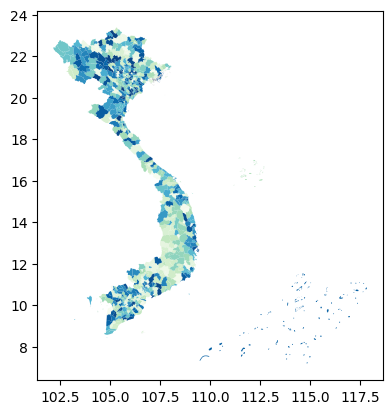

In [46]:
pop.plot(cmap='GnBu')